<a href="https://colab.research.google.com/github/space-owner/Tensorflow-2/blob/main/Text%20Classification%20with%20an%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Word embeddings***
This post is **based on the Tensorflow tutorial** for study purposes. [Link](https://www.tensorflow.org/tutorials)

***Learning Point:***
- **```tf.keras.Bidirectional()```**


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

print(">>> tf.version =", tf.__version__)

>>> tf.version = 2.6.0


In [5]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [6]:
dataset, info = tfds.load(
    'imdb_reviews', with_info=True, as_supervised=True
)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePJUQD8/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePJUQD8/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePJUQD8/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [8]:
for example, label in train_dataset.take(1):
    print(">>> text =", example.numpy())
    print(">>> label =", label.numpy())

>>> text = b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
>>> label = 0


In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [12]:
for example, label in train_dataset.take(1):
    print(">>> text =", example.numpy()[:3])
    print(">>> label =", label.numpy()[:3])

>>> text = [b'Watching the first 30 minutes of Sands of Oblivion gave me high hopes. It seemed I was in for a cheaper version of the Mummy. The setup was promising, in the 1920\'s Cecil B. Demille makes his opus of the Ten Commandments. It seems in using real Egyptian artifacts for the movie set they unleashed an ancient and terrible evil (don\'t they always?). Aware of what had been unleashed DeMille orders the entire set buried instead of the usual practice of tearing it down. Hopefully the evil will be buried with it for all time. Then we switch to present day where a team is attempting to excavate the site (the movie\'s first mistake, but hey those period costumes are expensive and this is a Sci-Fi channel movie). The first sightings we get of the Anubis monster are well done and it\'s a costume that they put some effort into and not the usual cheesy CG effect. Then the body counts starts. This is were the movie went south for me. The reactions to the fact that people are dying in 

In [13]:
VOCAB_SIZE = 1000

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE
)
encoder.adapt(
    train_dataset.map(lambda text, label: text)
)

In [14]:
vocab = np.array(encoder.get_vocabulary())

print(">>> vocab example =", vocab[:20])

>>> vocab example = ['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'for' 'with' 'movie' 'but']


In [16]:
encoded_example = encoder(example)[:3].numpy()

print(">>> encoded_example =", encoded_example)

>>> encoded_example = [[147   2  86 ...   0   0   0]
 [ 11   7   1 ...   0   0   0]
 [ 11 730   7 ...   0   0   0]]


In [17]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'Watching the first 30 minutes of Sands of Oblivion gave me high hopes. It seemed I was in for a cheaper version of the Mummy. The setup was promising, in the 1920\'s Cecil B. Demille makes his opus of the Ten Commandments. It seems in using real Egyptian artifacts for the movie set they unleashed an ancient and terrible evil (don\'t they always?). Aware of what had been unleashed DeMille orders the entire set buried instead of the usual practice of tearing it down. Hopefully the evil will be buried with it for all time. Then we switch to present day where a team is attempting to excavate the site (the movie\'s first mistake, but hey those period costumes are expensive and this is a Sci-Fi channel movie). The first sightings we get of the Anubis monster are well done and it\'s a costume that they put some effort into and not the usual cheesy CG effect. Then the body counts starts. This is were the movie went south for me. The reactions to the fact that people are dying in g

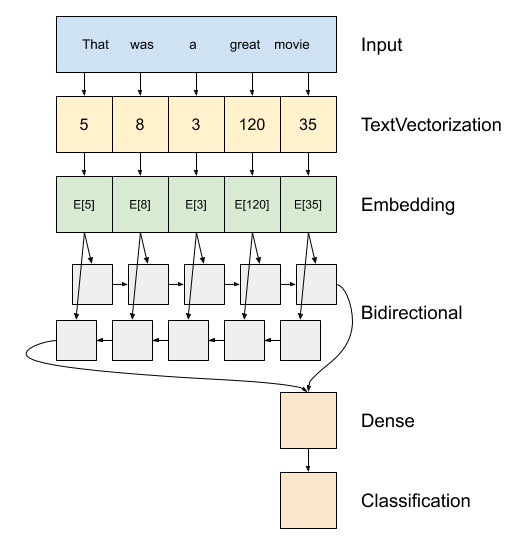

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64)
    ),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])